<a href="https://colab.research.google.com/github/blakebordelon/kernel_blogs/blob/master/kernel_regression_blog1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Theory of Generalization for Kernel Regression

Generalization is one of the central theoretical problems in machine learning. Understanding generalization amounts to answering the question: "When and why do algorithms trained on a finite sample perform well when tested on new data from the same distribution?"

In this blog post, I will explore generalization in the limited context of kernel regression and interpolation, a powerful algorithm with a rich history. 

## What are kernel methods and why should I care?

My research in kernel regression models grew out of my interest in the following questions.

1.   *Why do neural networks with many trainable parameters tend to generalize well rather than overfit?*
2.   *Broadly, how can learning algorithms capable of interpolating any training set of any size have good generalization guarantees?*  

The basic answer is that learning algorithms like kernel methods and gradient descent training in neural networks biases the solution towards *simple* interpolators for the provided dataset.  

In the next few blog posts, I hope to provide a kind of tutorial, showing how deeper understanding of kernel regression can help us answer these questions. In this post, I will focus mainly on question 2 by working through the main results of this [paper](https://arxiv.org/pdf/2002.02561.pdf), which is joint work with me (Blake Bordelon), Abdul Canatar and [Cengiz Pehlevan](https://pehlevan.seas.harvard.edu/) which explores the generalization properties of kernel machines. 

Kernel methods also propose a first pass approach to understanding generalization in neural networks. A recent (and growing) body of work has established an equivalence between kernel methods, [gradient descent training](https://arxiv.org/abs/1806.07572) and [Bayesian inference](https://arxiv.org/abs/2006.10541) in infinite width neural networks. Several interesting works have argued that, [to understand deep learning, we need to understand kernel learning](https://arxiv.org/abs/1802.01396). 

Towards that end, let's see if we can make some progress on kernel machines!

*Obligatory Caveat:* Kernel methods have a long history that I cannot do justice in a single post but I encourage anyone with general interest in this area to check out [Gaussian Processes for Machine Learning](http://www.gaussianprocess.org/gpml/chapters/RW.pdf) by Rasmussen and Williams and [Learning With Kernels](https://mitpress.mit.edu/books/learning-kernels) by Scholkopf and Smola.


## Kernel Regression Problem Statement

The learning algorithms we are considering have the form

$$ \min_{f \in \mathcal{H}} \sum_{i=1}^p (f(\mathbf{x}_i)-y_i)^2 + \lambda \left<f, f \right>_{\mathcal{H}}$$

where $\mathcal{H}$ is a *reproducing kernel Hilbert Space*. The first term in this optimization problem is simply a squared-error loss, while the second term is a regularizer that controls the complexity of the learned function. The first term can alternatively be interpreted as a negative-log-likelihood $- \sum_i \log p(y_i | f)$ under the assumption of Gaussian noise and independent sampling. The second term represents a negative-log-prior in the space of functions $-\log p(f)  = \lambda \left< f, f \right>_{\mathcal{H}}$. This optimization problem can therefore be interpreted as a [MAP algorithm](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation) over function space, where $p(\mathbf y | f) p(f)$ is maximized over function space.

The $\lambda \to 0$ limit is known as *kernel interpolation*, the solution to the following optimization problem

$$ \min_{f\in \mathcal{H}} \left< f,f \right>_{\mathcal{H}} \ \text{s.t.} \ f(\mathbf{x}_i) = y_i \ , \ i=1,...,p $$

Note that for $\lambda \to 0$, this problem chooses the function with minimum norm (with respect to $\mathcal{H}$) that perfectly interpolates the provided training data. Therefore, understanding how this kind of solution generalizes can provide insight into how models with large capacity (VC dimension, Rademacher complexity, etc) can generalize (see question 2 above). 

### Background on Hilbert Spaces (feel free to skip)
A Hilbert space $\mathcal{H}$ is a linear space (of potentially infinite dimension) equipped with an inner product $\left< \cdot , \cdot \right>_{\mathcal{H}}$ (a fancy dot product for functions). A function $f$ belongs in a Hilbert space $\mathcal{H}$ if it has finite norm $\left< f,f \right>_{\mathcal{H}} < \infty $. For a given probability measure $p(\mathbf{x})$, over the space of inputs, we introduce a set of orthonormal functions $\{\phi_\rho\}$ which satisfy $\left< \phi_\rho(\mathbf{x}) \phi_\gamma(\mathbf{x}) \right>_{x \sim p(\mathbf{x})} = \delta_{\rho,\gamma}$. These can be constructed with harmonic analysis or use of the Gram Schmidt procedure for $p(\mathbf{x})$. For example, the uniform measure on $[0,\pi]$ has the following complete set of orthonormal functions $\left \{\sqrt{\frac{2}{\pi}} \sin(kx),\sqrt{\frac{2}{\pi}} \cos(kx) \right\}_{k=0}^\infty$. 

The reproducing kernel $K$ for $\mathcal{H}$ is defined with the following reproducing property $\left< K(\mathbf{x},\cdot), g \right>_{\mathcal{H}} = g(\mathbf{x})$, which indicates equivalence between function evaluation at $\mathbf x$ and Hilbert product with $K(\mathbf x,\cdot)$. By Mercer's theorem, it also admits an eigendecomposition 

$$ K(\mathbf{x},\mathbf{x}') = \sum_{\rho} \lambda_\rho \phi_\rho(\mathbf{x}) \phi_\rho(\mathbf{x}')  \ , \int p(\mathbf{x}) K(\mathbf{x},\mathbf{x}') \phi_\rho(\mathbf{x}) d\mathbf{x} = \lambda_\rho \phi_\rho(\mathbf{x}')$$


Using orthonormality of the basis functions we can also develop a representation of the Hilbert norm. If $f(\mathbf{x}) = \sum_\rho a_\rho \phi_\rho(\mathbf{x})$ and $g(\mathbf{x}) = \sum_\rho b_\rho \phi_\rho(\mathbf{x})$
$$ \left< f,g \right>_{\mathcal{H}} = \sum_\rho \frac{\left< \phi_\rho(\mathbf{x}) f(\mathbf{x}) \right>_{\mathbf{x}\sim p(\mathbf{x})} \left< \phi_\rho(\mathbf{x}) g(\mathbf{x}) \right>_{\mathbf{x}\sim p(\mathbf{x})} }{\lambda_\rho} = \sum_\rho \frac{a_\rho b_\rho}{\lambda_\rho}$$

## Solution to Kernel Regression in Feature Space

We define features $\psi_\rho(\mathbf x)$ as rescaled versions of the orthonormal eigenfunctions $\psi_\rho(\mathbf{x}) = \sqrt{\lambda_\rho} \phi_\rho(\mathbf{x})$. If we expand functions in this basis $f(\mathbf{x}) = \sum_\rho w_\rho \psi_\rho(\mathbf{x})$, the Hilbert norm of $f$ becomes a simple $\ell_2$ norm on $\mathbf w$

$$ \left< f,f\right>_{\mathcal{H}} = \sum_\rho w_\rho^2 = ||\mathbf{w}||_2^2$$

In this basis, the analogy between Hilbert inner product of functions and the typical dot product of expansion coefficients $\mathbf w$ becomes precise. 

The original optimization problem can be rewritten in this basis as 
$$\min_{ ||w|| < \infty } ||\mathbf{\Psi}^\top \mathbf{w} - \mathbf{y}||^2  + \lambda ||\mathbf{w}||^2$$

where $\Psi_{\rho,i} = \psi_\rho(\mathbf{x}_i)$. 

This is just a simple [ridge regression problem](https://en.wikipedia.org/wiki/Tikhonov_regularization) (albeit in infinite dimensions). By setting the derivative of the objective with respect to $\mathbf{w}$ to zero, we find

$$ \mathbf{w}^* = (\mathbf{\Psi} \mathbf{\Psi}^\top + \lambda \mathbf{I})^{-1} \mathbf{\Psi} \mathbf{y} = (\mathbf{\Psi} \mathbf{\Psi}^\top + \lambda \mathbf{I})^{-1} \mathbf{\Psi} \mathbf{\Psi}^\top \mathbf{\overline{w}} = \mathbf{\overline{w}} - \lambda (\mathbf{\Psi} \mathbf{\Psi}^\top + \lambda \mathbf{I})^{-1} \mathbf{\overline{w}}$$

under the assumption that the targets are determined deterministically $y_i = \sum_\rho \overline{w}_\rho \psi_\rho(\mathbf{x}_i)$. 


Using this result for $w^*$, we can compute the value of the learned function at a test point with $f(x) = \psi(x) \cdot w^*$. After some algebra,

$$ f(x) = \sum_{i=1}^p \alpha_i K(x,x_i) , \ , \alpha = (\mathbf K + \lambda \mathbf I)^{-1} \mathbf y $$

What does this solution look like? In the next section we show an example.


## A simple Kernel Regression Experiment

We will draw inputs $\mathbf x \sim \text{Uniform}(\mathbb S^1) \subset \mathbb R^2$ which we parameterize as a vector $\mathbf x = [ \cos x, \sin x ]^\top$ for $x \in [-\pi,\pi]$. For simplicity, a pure harmonic is chosen as the target function $y(x) = \cos(kx)$. We will learn a kernel regression solution $f(x)$ and compare it to the ground truth. We will use the Neural Tangent Kernel (NTK), which describes how infinitely wide neural networks evolve under gradient descent for a depth 3 multi-layer perceptron with Relu nonlinearity. To conduct this experiment, we will use Google's [Neural Tangents](https://github.com/google/neural-tangents) package, which makes inference with infinite width networks a breeze.

In [ ]:
!pip install -q git+https://www.github.com/google/neural-tangents

import numpy as np
import math
import matplotlib.pyplot as plt
import jax.numpy as jnp

from jax import random
from jax.experimental import optimizers
from jax.api import jit, grad, vmap

import functools

import neural_tangents as nt
from neural_tangents import stax
import sys

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5905: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


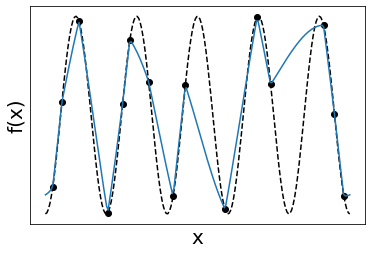

In [ ]:
width = 1000
depth = 3

# define a MLP with Relu nonlinearity at each layer
def fully_connected(w,d):
    layers = []
    for i in range(d):
        layers += [stax.Dense(w, W_std = 1, b_std = 0.1), stax.Relu()]
    layers += [stax.Dense(1, W_std=1, b_std = 0.1)]
    return stax.serial(*layers)

# create a 3 layer model with width 1000
init_fn, apply_fn, kernel_fn = fully_connected(width,depth)
kernel_fn = jit(kernel_fn, static_argnums=(2,))

# simple harmonic target function
def target(k, x):
    return np.cos(k*x)

# convert angle to vector on S^1
def trig(x):
    X = np.zeros((x.shape[0],2))
    X[:,0] = np.cos(x)
    X[:,1] = np.sin(x)
    return X


key = random.PRNGKey(2020)

# number of samples, frequency of target, regularization
p = 15
k = 5
lamb = 0

# generate training and test data
key, xkey = random.split(key)
x = 2*math.pi * random.uniform(key, (p,)) - math.pi * jnp.ones(p)
num_fine = 200
x_fine = np.linspace(-math.pi,math.pi, num_fine)
y = target(k, x)
y_fine = target(k,x_fine)

# Express the input as a vector on S^1 of the form [cos x, sin x]
X = trig(x)
X_fine = trig(x_fine)
x = jnp.reshape(x,(p,1))
x_fine = jnp.reshape(x_fine,(num_fine,1))
X = jnp.reshape(X,(p,2))
X_fine = jnp.reshape(X_fine, (num_fine, 2))


y = jnp.reshape(y, (p,1))

# kernel regression solution at test points
K = kernel_fn(X,X,'ntk')
K_te = kernel_fn(X_fine, X, 'ntk')
yhat = np.dot(K_te, np.dot(np.linalg.inv(K + lamb*jnp.eye(p)), y) )

# plot result
plt.plot(x_fine, y_fine, '--', color = 'black', label = 'target')
plt.plot(x_fine, yhat, label = 'kernel solution')
plt.scatter(x, y, color='black')
plt.xlabel('x', fontsize = 20)
plt.ylabel('f(x)', fontsize = 20)
plt.xticks([])
plt.yticks([])
plt.savefig('ntk_reg_ring_p%d.pdf' % p)
plt.show()




## Training a Wide but Finite Neural Network
Let's optimize a wide but finite neural network with the same architecture and dataset to compare to the kernel result. Instead of infinite width, we will use a neural network with 1000 hidden units. Although the NTK correspondence holds for full batch gradient descent with constant learning rate, we will use an adaptive step size which trains faster in practice. 

 training loss: 0.0000000

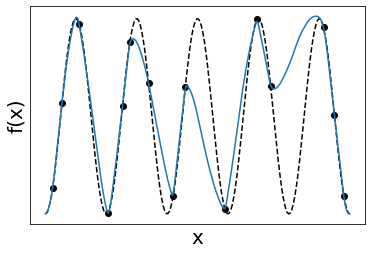

In [ ]:
# learning rate of the optimizer
lr = 1e-3
key = random.PRNGKey(0)
# initialize parameter and define MSE loss function 
key, paramkey = random.split(key)
_, params = init_fn(paramkey, (-1,2))
loss_fn = lambda params, X, y: jnp.mean( (apply_fn(params, X) - y)**2 )
grad_fn = lambda params,X,y: grad(loss_fn)(params, X, y)
opt_init, opt_update, get_params = optimizers.adam(lr)

# initialize optimizer
opt_state = opt_init(params)
for t in range(400):
    # take a gradient descent step
    opt_state = opt_update( t, grad_fn(get_params(opt_state), X, y), opt_state )
    loss = loss_fn(get_params(opt_state), X, y)
    sys.stdout.write('\r training loss: %.7f' % loss)

# plot the learned function
yhat_nn = apply_fn(get_params(opt_state), X_fine)
plt.plot(x_fine, y_fine, '--', color = 'black')
plt.plot(x_fine, yhat_nn)
plt.scatter(x, y, color='black')
plt.xlabel('x', fontsize=20)
plt.ylabel('f(x)', fontsize=20)
plt.xticks([])
plt.yticks([])
plt.savefig('real_nn_ring_p%d.pdf' % p)
plt.show()


We see that despite having too few samples to estimate the entire function perfectly, the bias of the learning algorithm prevents us from choosing a function with excessive high frequency content. It looks like both algorithms choose the simplest possible function that fits all of the data. We also note the similarity between the NTK regression solution and the result obtained from a finite network. 

Can we formalize this idea of inductive bias in a theory of kernel regression?

## Dream Theory

An ideal theory for kernel regression would take as free parameters 

1.   The data distribution $p(\mathbf x)$
2.   Kernel $K$ (or architecture for neural tangent kernel)
3.   Target Function $f_t(\mathbf x)$
4.   Number of Samples $p$

and from these parameters predicts expected generalization error $E_g$, which quantifies expected risk on a new sample from $p(\mathbf x)$.

Luckily, we are already pretty close. For instance, all of the information about the kernel $K$ and data distribution $p(\mathbf x)$ can be summarized by the diagonalization of the kernel: giving eigenvalues $\lambda_k$ and eigenfunctions $\psi_k(\mathbf x)$. The target function is also summarized by it's decomposition in this basis $f_t(\mathbf x) = \sum_\rho \overline{w}_\rho \psi_\rho(\mathbf x)$. Now it is just a matter of computing the expected generalization error


##Generalization Error Formula 

The generalization error when the method is trained on sample $\{\mathbf x_i\}$ can be obtained by exploiting the orthogonality of the eigenfunctions $\psi_\rho(\mathbf x)$

$$ E_g(\{\mathbf{x}_i\}) = (\mathbf w - \overline{\mathbf w})^\top \mathbf\Lambda (\mathbf w - \overline{\mathbf w}) = \lambda^2 \mathbf{\overline{w}} (\mathbf{\Psi} \mathbf{\Psi}^\top + \lambda \mathbf{I})^{-1} \mathbf{\Lambda} (\mathbf{\Psi} \mathbf{\Psi}^\top + \lambda \mathbf{I})^{-1} \mathbf{\overline{w}}$$

This quadratic form gives the generalization error for kernel regression for a given sample $\{\mathbf{x}_i\}$. However, we desire a *typical* estimate of generalization, motivating an *average* of this quantity over all possible training samples of size $p$. The remainder of the paper deals with different theoretical strategies to average over possible samples of size $p$ to obtain a typical performance estimate. 


It turns out that it suffices to average the following matrix

$$ G(p, v) = \left< \left( \frac{1}{\lambda} \mathbf{\Phi} \mathbf{\Phi}^\top + \mathbf{\Lambda}^{-1} + v \mathbf{I} \right)^{-1} \right>$$

over the data distribution where $\mathbf{\Phi} = \mathbf{\Lambda}^{-1/2} \mathbf{\Psi}$.

In the paper, we compute an approximation of this "quenched" average in two different ways: 
1. Leave-one-out technique that uses the [Sherman-Morrison formula](https://en.wikipedia.org/wiki/Sherman%E2%80%93Morrison_formula). This generates a PDE which can be solved with the [method of characteristics](https://en.wikipedia.org/wiki/Method_of_characteristics#:~:text=In%20mathematics%2C%20the%20method%20of,for%20solving%20partial%20differential%20equations.&text=The%20method%20is%20to%20reduce,given%20on%20a%20suitable%20hypersurface.). This technique is inspired by an old paper by [Peter Sollich](https://arxiv.org/abs/cond-mat/0106475). 
2. [Replica trick](https://en.wikipedia.org/wiki/Replica_trick) from statistical physics


If interested, you can see the Supplementary Information in the [paper](https://arxiv.org/abs/2002.02561) for more details. Both computational strategies give the same prediction for the elements of $G$
$$ G(p,v)_{\rho,\gamma} = \frac{\delta_{\rho,\gamma} }{\frac{p}{z} + \frac{1}{\lambda_\rho} + v}$$

where $z$ satisfies the following self consistency equation that can be solved numerically
$$  z = \lambda + z \sum_\rho \frac{\lambda_\rho }{\lambda_\rho p + z} $$

This nonlinear equation introduces non-trivial coupling between modes $\rho$.

The *typical* generalization error can be expressed in terms of this function $z$ as well as the number 
of samples $p$, the kernel eigenspectrum $\lambda_\rho$ and the target power spectrum $\overline{w}_\rho$

$$ E_g = \frac{z^2}{1-p \gamma} \sum_\rho \frac{ \overline{w}_\rho^2 \lambda_\rho}{(\lambda_\rho p + z)^2} ,  \ z = \lambda + z \sum_\rho \frac{\lambda_\rho }{\lambda_\rho p + z} ,  \gamma = \sum_\rho \frac{\lambda_\rho^2}{(\lambda_\rho p + z)^2 } $$


## Spectral Bias
We also see that the generalization error contains a sum of terms that only depend on information for each mode $\rho$. We define these modal contributions to the total error as mode errors $E_\rho$

$$ E_\rho = \frac{z^2}{1-p \gamma} \frac{ \overline{w}_\rho^2 \lambda_\rho}{(\lambda_\rho p + z)^2} $$


These errors exhibit *spectral bias*, in the sense that a marginal data point causes a greater percent reduction in the mode errors of modes with large eigenvalues. Mathematically, the logarithmic derivatives of $E_\rho$ have the same ordering as the eigenvalues:

$$ \lambda_\rho > \lambda_\gamma \iff \frac{d}{dp} \log E_\rho  < \frac{d}{dp} \log E_\gamma $$ 

### Compatible Target Functions

As a consequence of *spectral bias*, target functions that place a large portion of power in modes with small eigenvalues take a large number of samples to learn. Conversely, a target function possessing a power spectrum with the same ordering as the kernel eigenspectrum can be learned rapidly.


## Power Law Scalings

Let's specialize to the case where the kernel eigenvalues and the target power spectrum fall in a power law. 

$$  \lambda_\rho = \rho^{-b} \ , \ \overline{w}_\rho^2 \lambda_\rho = \rho^{-a}$$

for $\rho=1,2,...$. 

With this choice, we can compute the large $p$ scaling of the generalization error and find that it falls in a powerlaw. 

$$ E_g \sim p^{- \min\{a-1, 2b \} }  \ , \ p < \lambda^{-1/(b-1)} $$

$$ E_g \sim p^{- \min\{ a-1, 2b \} / b } \ , \ p > \lambda^{-1/(b-1)} $$ 

This result exactly recovers the power law scaling identified for [translation invariant kernel regression](https://arxiv.org/abs/1905.10843) on MNIST and CIFAR 10 by Spigler, Geiger and Wyart 2020. The scalings for this case demonstrate that explicit regularization hinders performance by reducing the decay exponent ($b$ must be greater than 1 for the kernel to have finite trace $T = \left< K(\mathbf x,\mathbf x) \right>_{\mathbf x} = \sum_\rho \lambda_\rho$) and that best performance is attained if $b > b^* = \frac{a-1}{2}$. Thus "smooth" kernels outperform rough kernels until $b > b^*$. The error decays more rapidly if the target power spectrum decays rapidly (large $a$). 

## Real Datasets

Does this theory have anything interesting to say about realistic data distributions? Suppose we want to characterize the performance of a certain neural tangent kernel for recognizing hand-written digits. 

$$ \int K(\mathbf x, \mathbf x') \phi_\rho(\mathbf x) p(\mathbf x) d \mathbf x= \lambda_\rho \phi_\rho(\mathbf x') $$

To confront this integral eigenvalue problem we use a Monte-Carlo estimate of the data density, introduing the empirical measure $p(\mathbf x) = \frac{1}{N}\sum_{i=1}^N \delta(\mathbf x - \mathbf x_i)$. Inserting this density into the integral equation generates a simple matrix equation

$$ \frac{1}{N} \mathbf K \mathbf\Phi^\top = \mathbf \Phi \mathbf\Lambda $$

where $K_{ij} = K(\mathbf x_i, \mathbf x_j) $ and $\Phi_{\rho,i} = \phi_\rho(\mathbf{x}_i)$ and $\Lambda_{\rho,\gamma} = \lambda_\rho \delta_{\rho,\gamma}$. This is just a $N \times N$ matrix eigendecomposition of the kernel gram matrix $\mathbf K$. 

We can translate the decomposition of the target function into a simple projection of the target labels on the kernel's principal subspace. 
$$ \overline{w}_\rho = \lambda_\rho^{-1/2} \int p(\mathbf x) \phi_\rho(\mathbf x) f_t(\mathbf x) d\mathbf x \implies \mathbf{\overline{w}} = N^{-1} \mathbf{\Lambda}^{-1/2} \mathbf\Phi^{\top} \mathbf{y} $$

With $\mathbf\Lambda$ and $\overline{\mathbf w}$, we can compute theoretical learning curves using the equations derived in the previous section. 

We also introduce a cumulative target power measure 

$$ C(k) = \frac{1}{\sum_\rho \overline{w}_\rho^2 \lambda_\rho} \sum_{\rho < k} \overline{w}_\rho^2 \lambda_\rho $$

which provides a cumulative distribution over the target functions power spectrum. Target functions with quickly rising $C(k)$ are easy to learn with the chosen kernel, whereas target functions with slowly rising $C(k)$ take a large number of samples to learn.



# Regression Task on MNIST
We will illustrate the main components of the theory by evaluating kernel regression on handwritten digits for two different pairs of digits. First, we will attempt to discriminate between 8's and 9's and then between 0's and 1's. We expect it is easier to discriminate between 0's and 1's since 8's and 9's look more similar. Can we see why this would happen from our theory?

First, we will import some useful libraries.  

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from google.colab import drive
import scipy as sp
import scipy.optimize
import pandas as pd
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Define Functions to Compute Theoretical Learning Curves

In [ ]:
# gets experimental E_g(p)
def get_learning_curve(pvals, K, y):
  err = np.zeros(len(pvals))
  num_repeats = 20
  for n in range(num_repeats):
    for i, p in enumerate(pvals):
      inds = np.random.randint(0,K.shape[0], int(p))
      Ki = K[inds, :]
      Kii = Ki[:,inds]
      yi = y[inds,:]
      yhat = Ki.T @ np.linalg.inv(Kii + p*1e-8*np.eye(int(p))) @ yi
      err[i] += 1/num_repeats* np.mean( (yhat - y)**2 )
  return err
  
# implicit equation for z
def implicit_fn_true(z,*args):
    (p, lamb, spectrum) = args
    return z - lamb - z * np.dot(spectrum, (p*spectrum + z*np.ones(len(spectrum)) )**(-1))

# derivative of implicit function
def f_prime_true(z,*args):
    (p, lamb, spectrum) = args
    return 1 - np.dot(spectrum, (p*spectrum + z*np.ones(len(spectrum)) )**(-1)) + z* np.dot(spectrum, (p*spectrum + z*np.ones(len(spectrum)) )**(-2))

# solve implicit equation with Newton's method
def solve_implicit_z(spectrum, pvals, lamb):
    sols = np.zeros(len(pvals))
    for i, p in enumerate(pvals):
        args = (p, p*lamb, spectrum)
        sols[i] = sp.optimize.root_scalar(implicit_fn_true, x0= p * np.amax(spectrum), args = args, fprime = f_prime_true, method = 'newton').root
    return sols

# compute theory learning curve E_g(p)
def compute_theory(pvals, spectrum, teacher, lamb):
  errs = np.zeros(len(pvals))
  zvals = solve_implicit_z(spectrum, pvals, lamb)
  for i, p in enumerate(pvals):
    zi = zvals[i]
    gamma = np.sum( spectrum**2 / (spectrum*p+zi)**2 )
    errs[i] = zi**2/(1-gamma*p) * np.sum(teacher / (spectrum*p+zi)**2 )
  return errs / len(spectrum)


## Download and Preprocess Data

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.
(50000, 784)


/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5905: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


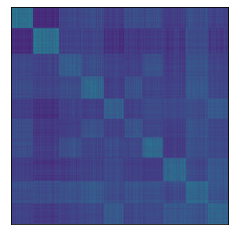

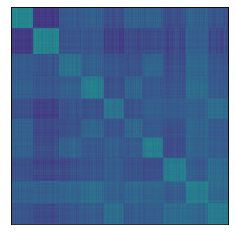

In [ ]:
# Download MNIST
num_tot = 50000
dataset_name = 'MNIST'
num_classes = 10
size = 32
name = 'mnist'
ds = tfds.load(name, split=tfds.Split.TRAIN).shuffle(1024).batch(num_tot)


for i,ex in enumerate(ds):
  Xtf = ex['image']
  image = Xtf.numpy() / 255.0
  X = np.reshape(image, (image.shape[0], image.shape[1]*image.shape[2]*image.shape[3]))
  X = X / np.outer(np.linalg.norm(X, axis = 1), np.ones(X.shape[1]))
  y = ex['label'].numpy()
  y = np.eye(num_classes)[y] 
  break

print(X.shape)

# define a RELU neural tangent kernel
_,_,kernel_fn = stax.serial( stax.Dense(100), stax.Relu(), stax.Dense(1), stax.Relu(), stax.Dense(1) )
kernel_fn = jit(kernel_fn, static_argnums=(2,))

inds_rand = np.random.randint(0, 50000, 5000)
sorted_inds = []
for i in range(10):
  inds_i = [j for j in inds_rand if y[j,i] == 1]
  sorted_inds += inds_i

# compute NTK and NNGP kernel matrices
K0_ntk = kernel_fn(X[sorted_inds,:],None,'ntk') 
K0_nngp = kernel_fn(X[sorted_inds,:],None,'nngp')

# plot NTK matrix visual
plt.imshow(100*K0_ntk)
plt.xticks([])
plt.yticks([])
plt.savefig(root_dir + 'ntk_matrix_visual.pdf')
plt.show()
plt.imshow(100*K0_nngp)
plt.xticks([])
plt.yticks([])
plt.savefig(root_dir + 'nngp_matrix_visual.pdf')
plt.show()


# Perform Eigendecomposition to get Eigenvalues and Eigenvectors of the Kernel

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5905: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/usr/local/lib/python3.6/dist-packages/jax/numpy/lax_numpy.py:3285: UserWarning: 'kind' argument to argsort is ignored.
  warnings.warn("'kind' argument to argsort is ignored.")


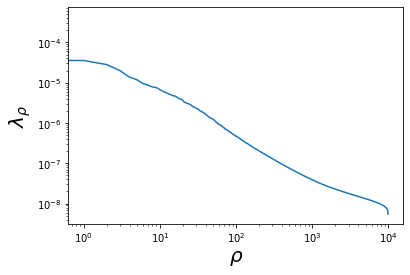

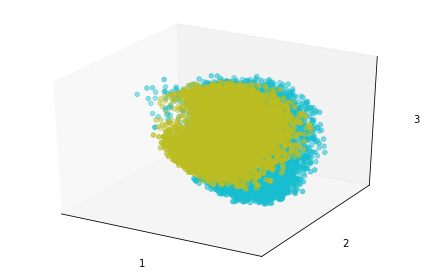

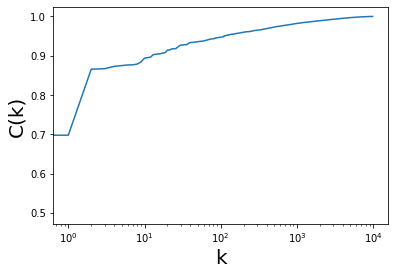

"\nfig = plt.figure()\nax = fig.add_subplot(111, projection='3d')\n\n\nfor i in [1,2,7]:\n  inds_i = [j for j in range(len(y)) if y[j,i] == 1]\n  ax.scatter(proj[0,inds_i], proj[1,inds_i], proj[2,inds_i])\nax.xaxis.set_ticks([])\nax.yaxis.set_ticks([])\nax.zaxis.set_ticks([])\n\nplt.savefig('mnist_kpc_visual.pdf')\nplt.show()\n\n\nfor i in [0,1,7]:\n  inds_i = [j for j in range(len(y)) if y[j,i] == 1]\n  plt.scatter(proj[0,inds_i], proj[1,inds_i])\nplt.xticks([])\nplt.yticks([])\nplt.show()\n"

In [ ]:
# choose only 8's and 9's for a two-way regression task
# We expect this to be a difficult since 8 and 9's look similar
a = 8
b = 9
inds_01 = [i for i in range(len(y)) if y[i,a]==1 or y[i,b]==1]

K = kernel_fn(X[inds_01,:],None,'ntk')

# perform regression experiment
pvals = np.logspace(0,3,12)
lc_1 = get_learning_curve(pvals, K, y[inds_01,:])


# perform eigendecomposition
spectrum, vecs = jnp.linalg.eigh(1/K.shape[0] * K)
inds_sort = np.argsort(spectrum)
inds_sort = inds_sort[::-1]
spectrum = spectrum[inds_sort]
vecs = vecs[:,inds_sort]

# plot kernel eigenspectrum spectrum
plt.loglog(spectrum)
plt.xlabel(r'$\rho$', fontsize=20)
plt.ylabel(r'$\lambda_\rho$', fontsize = 20)
plt.show()

# get target spectrum 
teacher = np.mean((vecs.T @ y[inds_01,:])**2, axis = 1)
theory_lc_1 = compute_theory(pvals, spectrum, teacher, 1e-8)


# 8-9 projection to kernel subspace
proj_89 = vecs[:,0:10].T @ K
pd.DataFrame(proj_89).to_csv(root_dir + 'projs_%d_%d.csv' % (a,b))
y2=y[inds_01,:]
pd.DataFrame(y2).to_csv(root_dir + 'labels_%d_%d.csv' % (a,b))



proj = vecs[:,0:3].T @ K

# plot K-PC projection
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
y2 = y[inds_01,:]
for i in [a,b]:
  inds_i = [j for j in range(len(y2)) if y2[j,i]==1]
  ax.scatter(proj[0,inds_i], proj[1,inds_i], proj[2,inds_i], color = 'C%d' % i)
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
ax.zaxis.set_ticks([])
ax.set_xlabel('1')
ax.set_ylabel('2')
ax.set_zlabel('3')
plt.tight_layout()
plt.savefig(root_dir + 'mnist_%d_%d_kpc_visual.pdf' % (a,b))
plt.show()

power = np.sum( (vecs.T @ y2)**2, axis = 1)
cumul = np.cumsum(power) / np.sum(power)
plt.semilogx(cumul)
plt.xlabel('k', fontsize = 20)
plt.ylabel('C(k)', fontsize = 20)
plt.show()

"""
sorted_power = np.argsort(power)[::-1]
proj_sort = vecs[:,sorted_power[0:3]].T @ K
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
y2 = y[inds_01,:]
for i in [a,b]:
  inds_i = [j for j in range(len(y2)) if y2[j,i]==1]
  ax.scatter(proj_sort[0,inds_i], proj_sort[1,inds_i], proj_sort[2,inds_i], color = 'C%d' % i)
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
ax.zaxis.set_ticks([])
ax.set_xlabel('%d' % (1+sorted_power[0]))
ax.set_ylabel('%d' % (sorted_power[1]+1))
ax.set_zlabel('%d' % (sorted_power[2]+1))
plt.tight_layout()

plt.savefig(root_dir + 'mnist_%d_%d_kpc_visual_highest_var.pdf' % (a,b))
plt.show()
"""



"""
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


for i in [1,2,7]:
  inds_i = [j for j in range(len(y)) if y[j,i] == 1]
  ax.scatter(proj[0,inds_i], proj[1,inds_i], proj[2,inds_i])
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
ax.zaxis.set_ticks([])

plt.savefig('mnist_kpc_visual.pdf')
plt.show()


for i in [0,1,7]:
  inds_i = [j for j in range(len(y)) if y[j,i] == 1]
  plt.scatter(proj[0,inds_i], proj[1,inds_i])
plt.xticks([])
plt.yticks([])
plt.show()
"""

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5905: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/usr/local/lib/python3.6/dist-packages/jax/numpy/lax_numpy.py:3285: UserWarning: 'kind' argument to argsort is ignored.
  warnings.warn("'kind' argument to argsort is ignored.")


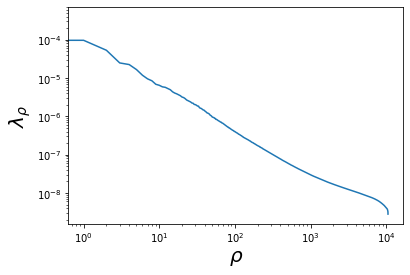

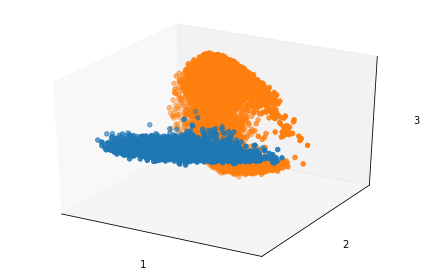

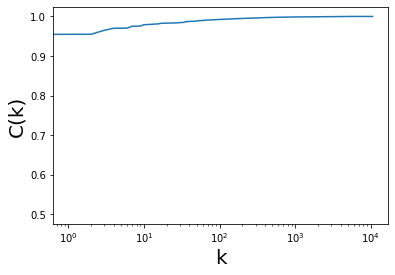

"\nsorted_power = np.argsort(power)[::-1]\nproj_sort = vecs[:,sorted_power[0:3]].T @ K\nfig = plt.figure()\nax = fig.add_subplot(111, projection='3d')\ny2 = y[inds_01,:]\nfor i in [a,b]:\n  inds_i = [j for j in range(len(y2)) if y2[j,i]==1]\n  ax.scatter(proj_sort[0,inds_i], proj_sort[1,inds_i], proj_sort[2,inds_i], color = 'C%d' % i)\nax.xaxis.set_ticks([])\nax.yaxis.set_ticks([])\nax.zaxis.set_ticks([])\nax.set_xlabel(r'$%d$' % (sorted_power[0]+1))\nax.set_ylabel(r'$%d$' % (sorted_power[1]+1))\nax.set_zlabel(r'$%d$' % (sorted_power[2]+1))\nplt.tight_layout()\nplt.savefig(root_dir + 'mnist_%d_%d_kpc_visual_highest_var.pdf' % (a,b))\nplt.show()\n"

In [ ]:
# now, let's do the same with 0s and 1s
a = 0
b = 1
inds_01 = [i for i in range(len(y)) if y[i,a]==1 or y[i,b]==1]
K = kernel_fn(X[inds_01,:],None,'ntk')

# experimental learning curve
lc_2 = get_learning_curve(pvals, K, y[inds_01,:])

# eigendecomposition
spectrum, vecs = jnp.linalg.eigh(1/K.shape[0] * K)
inds_sort = np.argsort(spectrum)
inds_sort = inds_sort[::-1]
spectrum = spectrum[inds_sort]
vecs = vecs[:,inds_sort]

# plot kernel spectrum
plt.loglog(spectrum)
plt.xlabel(r'$\rho$', fontsize = 20)
plt.ylabel(r'$\lambda_\rho$', fontsize=20)
plt.show()

# plot projections to principal subspace
proj_01 = vecs[:,0:10].T @ K
pd.DataFrame(proj_01).to_csv(root_dir + 'projs_%d_%d.csv' % (a,b))
y2=y[inds_01,:]
pd.DataFrame(y2).to_csv(root_dir + 'labels_%d_%d.csv' % (a,b))

# get theory curves
teacher = np.mean((vecs.T @ y[inds_01,:])**2, axis = 1)
theory_lc_2 = compute_theory(pvals, spectrum, teacher, 1e-8)



# compute projection onto first 2 components 
#  K phi = lambda phi  

proj = vecs[:,0:3].T @ K
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
y2 = y[inds_01,:]
for i in [a,b]:
  inds_i = [j for j in range(len(y2)) if y2[j,i]==1]
  ax.scatter(proj[0,inds_i], proj[1,inds_i], proj[2,inds_i], color = 'C%d' % i)

ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
ax.zaxis.set_ticks([])
ax.set_xlabel(r'$1$')
ax.set_ylabel(r'$2$')
ax.set_zlabel(r'$3$')
plt.tight_layout()

plt.savefig(root_dir + 'mnist_%d_%d_kpc_visual.pdf' % (a,b))
plt.show()



# get power
power = np.sum( (vecs.T @ y2)**2, axis = 1)
cumul2 = np.cumsum(power) / np.sum(power)

plt.semilogx(cumul2)
plt.xlabel('k', fontsize = 20)
plt.ylabel('C(k)', fontsize = 20)
plt.show()

"""
sorted_power = np.argsort(power)[::-1]
proj_sort = vecs[:,sorted_power[0:3]].T @ K
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
y2 = y[inds_01,:]
for i in [a,b]:
  inds_i = [j for j in range(len(y2)) if y2[j,i]==1]
  ax.scatter(proj_sort[0,inds_i], proj_sort[1,inds_i], proj_sort[2,inds_i], color = 'C%d' % i)
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
ax.zaxis.set_ticks([])
ax.set_xlabel(r'$%d$' % (sorted_power[0]+1))
ax.set_ylabel(r'$%d$' % (sorted_power[1]+1))
ax.set_zlabel(r'$%d$' % (sorted_power[2]+1))
plt.tight_layout()
plt.savefig(root_dir + 'mnist_%d_%d_kpc_visual_highest_var.pdf' % (a,b))
plt.show()
"""



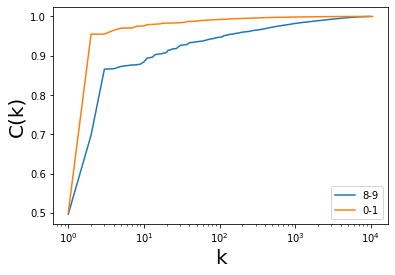

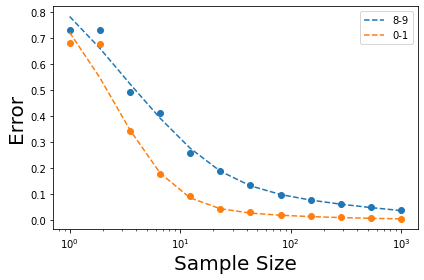

In [ ]:
plt.semilogx(np.linspace(1,len(cumul),len(cumul)), cumul, label = '8-9')
plt.semilogx(np.linspace(1,len(cumul2),len(cumul2)), cumul2, label = '0-1')
plt.xlabel('k', fontsize = 20)
plt.ylabel('C(k)', fontsize =20)
plt.legend()
plt.savefig(root_dir + 'cumulative_power_kpc.pdf')
plt.show()


plt.semilogx(pvals, 10*lc_1, 'o', color = 'C0')
plt.semilogx(pvals, 10*theory_lc_1, '--', color ='C0', label = '8-9')
plt.semilogx(pvals, 10*lc_2, 'o', color = 'C1')
plt.semilogx(pvals, 10*theory_lc_2, '--', color ='C1', label = '0-1')
plt.xlabel('Sample Size', fontsize = 20)
plt.ylabel('Error', fontsize = 20)
plt.legend()
plt.tight_layout()
plt.savefig(root_dir + 'binary_learning_curves.pdf')
plt.show()

# Conclusion

We see that the theory curves (shown in dashed lines) agree very well with the experimental errors, especially at large $p$ where the saddle point approximation is valid. Further, the 0-1 task, which possesses a quickly rising cumulative power distribution $C(k)$ has lower test error for each $p$ than the 8-9 task which has a slowly rising $C(k)$.  

This theory is not meant to be a replacement for cross-validation: in practice generalization is always determined with held out test data. However, the development of this theory provides tools for understanding when and why a chosen kernel will generalize when trained on samples from a certain data distribution. 

Future work could explore architecture of neural tangent kernels (convolutions, pooling, etc) and their impact on sample efficiency for image datasets. In addition, some lines of work have suggested that neural networks in the feature learning regime [compress irrelevant dimensions](https://arxiv.org/abs/2007.11471) and that kernel methods/lazy neural networks perform equally well on compressed datasets. It would be interesting to continue this line of work with the insights of our theory by exploring anisotropic distributions $p(x)$. 